In [1]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
%matplotlib inline


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [2]:
data_f = pd.read_csv("df.csv",na_values=['na','-'])

In [3]:
data_f.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,NaN,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,NaN,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,NaN,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,NaN,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [4]:
data_f.drop(labels=['id'],axis=1,inplace=True)
data_f.dropna(axis=0,inplace=True)

In [5]:
data_f.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
11,2.093085,tcp,smtp,FIN,62,28,56329,2212,42.520967,62,...,1,2,0,0,0,1,1,0,Normal,0
15,0.000002,udp,snmp,INT,2,0,138,0,500000.001300,254,...,1,4,0,0,0,2,1,0,Normal,0
17,0.393556,tcp,http,FIN,10,8,860,1096,43.195886,62,...,1,2,0,0,1,1,3,0,Normal,0
21,0.338017,tcp,http,FIN,10,6,998,268,44.376468,254,...,1,1,0,0,1,2,3,0,Normal,0


In [6]:
data_f.shape

(116352, 44)

# Data Preprocessing

In [7]:
encode_text_dummy(data_f,'service')
encode_text_dummy(data_f,'proto')
encode_text_dummy(data_f,'state')
encode_text_dummy(data_f,'attack_cat')

In [8]:
data_f.shape

(116352, 69)

In [9]:
x = data_f.drop(['label'], axis = 1, inplace=False)
y = data_f.loc[:,'label']

In [10]:
x

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state-RST,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,0,0,0,0,0,0,0,1,0,0
11,2.093085,62,28,56329,2212,42.520967,62,252,2.118251e+05,8152.559082,...,0,0,0,0,0,0,0,1,0,0
15,0.000002,2,0,138,0,500000.001300,254,0,2.760000e+08,0.000000,...,0,0,0,0,0,0,0,1,0,0
17,0.393556,10,8,860,1096,43.195886,62,252,1.573347e+04,19494.048830,...,0,0,0,0,0,0,0,1,0,0
21,0.338017,10,6,998,268,44.376468,254,252,2.127704e+04,5301.508789,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256803,0.818276,60,14,68199,612,89.211954,254,252,6.556516e+05,5562.915039,...,0,0,0,0,0,0,0,1,0,0
256807,0.825170,60,14,68199,612,88.466621,254,252,6.501739e+05,5516.438965,...,0,0,0,0,0,0,0,1,0,0
256859,0.874942,60,14,68199,612,83.434101,254,252,6.131881e+05,5202.630371,...,0,0,0,0,0,0,0,1,0,0
256881,0.740231,60,14,68199,612,98.617867,254,252,7.247792e+05,6149.432129,...,0,0,0,0,0,0,0,1,0,0


In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

In [12]:
x_test.shape

(23271, 68)

In [13]:
y_train.shape

(93081,)

In [14]:
y_test.shape

(23271,)

In [15]:
x_train.shape

(93081, 68)

In [16]:
for column in x_train.columns:
    encode_numeric_zscore(x_train, column)
    encode_numeric_zscore(x_test, column)

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [17]:
x_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,state-RST,attack_cat-Analysis,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Exploits,attack_cat-Fuzzers,attack_cat-Generic,attack_cat-Normal,attack_cat-Reconnaissance,attack_cat-Worms
204498,-0.197869,-0.09812,-0.110529,-0.056017,-0.075764,-0.615234,-1.361077,-0.452999,-0.613025,0.419033,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,-0.994306,1.732550,-0.140345,-0.034863
211445,-0.191910,0.17007,0.173206,0.096261,-0.058511,-0.610321,-1.361077,-0.452999,-0.472488,0.858346,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,-0.994306,1.732550,-0.140345,-0.034863
156267,-0.198126,-0.09812,-0.124715,-0.056083,-0.076633,0.854842,0.813785,-0.714227,0.822270,-0.215504,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,1.005716,-0.577178,-0.140345,-0.034863
206052,-0.197852,-0.09812,-0.110529,-0.056017,-0.075764,-0.616292,-1.361077,-0.452999,-0.613415,0.379731,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,-0.994306,1.732550,-0.140345,-0.034863
159456,-0.198127,-0.09812,-0.124715,-0.056083,-0.076633,5.316303,0.813785,-0.714227,5.147034,-0.215504,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,1.005716,-0.577178,-0.140345,-0.034863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60768,0.093107,0.21298,-0.025408,0.223380,-0.073352,-0.631943,0.813785,1.555757,-0.613561,-0.211552,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,7.101086,-0.994306,-0.577178,-0.140345,-0.034863
131754,-0.198125,-0.09812,-0.124715,-0.056083,-0.076633,0.028645,0.813785,-0.714227,0.021388,-0.215504,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,1.005716,-0.577178,-0.140345,-0.034863
127450,-0.198125,-0.09812,-0.124715,-0.056083,-0.076633,0.028645,0.813785,-0.714227,0.021388,-0.215504,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,1.005716,-0.577178,-0.140345,-0.034863
128726,-0.198126,-0.09812,-0.124715,-0.056083,-0.076633,0.854842,0.813785,-0.714227,0.822270,-0.215504,...,-0.011819,-0.068522,-0.030936,-0.149615,-0.477166,-0.140822,1.005716,-0.577178,-0.140345,-0.034863


In [18]:
x_train.dropna(axis=1,inplace=True)

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
x_test.dropna(axis=1,inplace=True)

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
x_train.shape

(93081, 67)

In [21]:
x_test.shape

(23271, 66)

In [22]:
x_train.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'service-dhcp', 'service-dns',
       'service-ftp', 'service-ftp-data', 'service-http', 'service-irc',
       'service-pop3', 'service-radius', 'service-smtp', 'service-snmp',
       'service-ssh', 'service-ssl', 'proto-tcp', 'proto-udp', 'state-ACC',
       'state-CON', 'state-FIN', 'state-INT', 'state-REQ', 'state-RST',
       'attack_cat-Analysis', 'attack_cat-Backdoor', 'attack_cat-DoS',
       'attack_cat-Exploits', 'attack_cat-Fuzzers', 'attack_cat-Generic',
       'attack_cat-Normal', 'attack_cat-Re

In [23]:
x_test.columns

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'service-dhcp', 'service-dns',
       'service-ftp', 'service-ftp-data', 'service-http', 'service-irc',
       'service-pop3', 'service-radius', 'service-smtp', 'service-snmp',
       'service-ssh', 'service-ssl', 'proto-tcp', 'proto-udp', 'state-CON',
       'state-FIN', 'state-INT', 'state-REQ', 'state-RST',
       'attack_cat-Analysis', 'attack_cat-Backdoor', 'attack_cat-DoS',
       'attack_cat-Exploits', 'attack_cat-Fuzzers', 'attack_cat-Generic',
       'attack_cat-Normal', 'attack_cat-Reconnaissance'

In [24]:
#x_train.drop(labels=['is_sm_ips_ports'],axis=1,inplace=True)
#x_test.drop(labels=['is_sm_ips_ports'],axis=1,inplace=True)
x_train.drop(labels=['state-ACC'],axis=1,inplace=True)
#x_test.drop(labels=['state-ACC'],axis=1,inplace=True)

C:\Users\Prerak\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr=LogisticRegression()
lr.fit(x_train,y_train)

C:\Users\Prerak\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred = lr.predict(x_test)
print('Accuracy of logistic regression classifier on test set:',lr.score(x_test, y_test))

Accuracy of logistic regression classifier on test set: 1.0


[[ 5853     0]
 [    0 17418]]


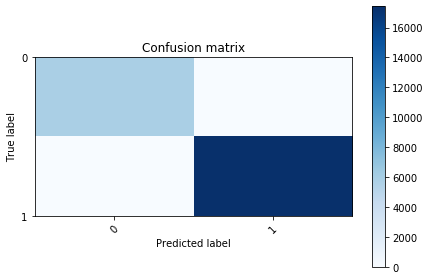

In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



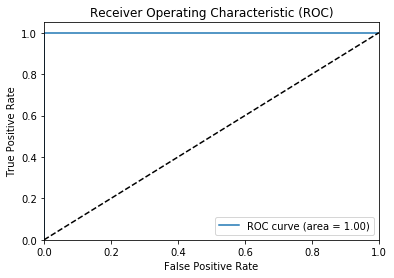

In [29]:
plot_roc(y_pred,y_test)

# SVM

In [30]:
from sklearn.svm import SVC
svm_object = SVC(kernel = 'rbf')
svm_object.fit(x_train, y_train)
y_pred = svm_object.predict(x_test)

C:\Users\Prerak\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 5847     6]
 [    0 17418]]


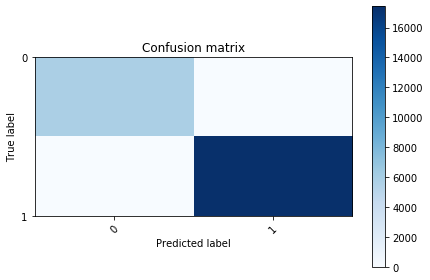

In [31]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [32]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9997421683640583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



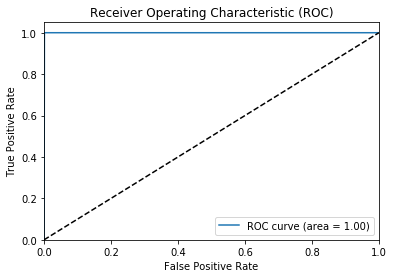

In [33]:
plot_roc(y_pred,y_test)

# KNN 

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

[[ 5847     6]
 [    0 17418]]


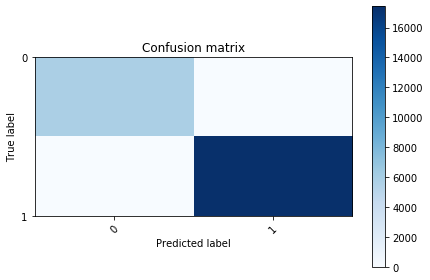

In [35]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

Accuracy: 0.9997421683640583
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



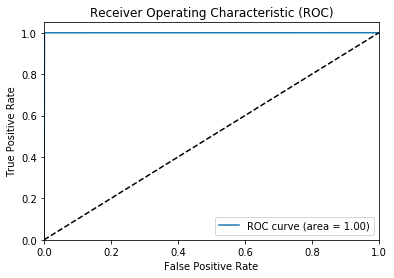

In [36]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
y_pred = knn.predict(x_test)
print(classification_report(y_test,y_pred))
plot_roc(y_pred,y_test)

# NEURAL NETWORKS

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [38]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)

array([[-0.19677559, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003],
       [-0.19677559, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003],
       [-0.19677559, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003],
       ...,
       [-0.19677684, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003],
       [-0.19677709, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003],
       [-0.19677709, -0.10110708, -0.15754166, ..., -0.57966995,
        -0.13375044, -0.03881003]], dtype=float32)

In [39]:
y_train = to_categorical(y_train)             #don't do again and again
y_test = to_categorical(y_test)            #don't do again and again




Model trained for "adam" optimizer and "relu" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 13s - loss: 0.0084 - val_loss: 0.0021
Epoch 2/200
93081/93081 - 12s - loss: 0.0044 - val_loss: 0.0014
Epoch 3/200
93081/93081 - 12s - loss: 6.0805e-04 - val_loss: 0.0014
Epoch 4/200
93081/93081 - 12s - loss: 7.7143e-04 - val_loss: 0.0025
Epoch 5/200
93081/93081 - 12s - loss: 0.0027 - val_loss: 0.0014
Epoch 6/200
93081/93081 - 12s - loss: 0.0026 - val_loss: 0.0014
Epoch 00006: early stopping

Confusion Matrix

[[ 5853     0]
 [    2 17416]]


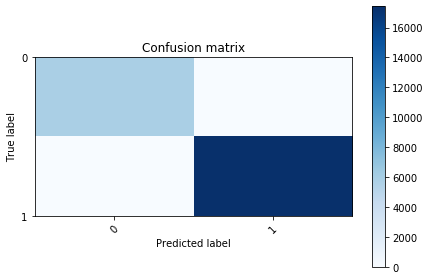


Accuracy

Final accuracy: 0.9999140561213528

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.0198 - val_loss: 2.5600e-04
Epoch 2/200
93081/93081 - 12s - loss: 1.6843e-04 - val_loss: 1.5216e-04
Epoch 3/200
93081/93081 - 12s - loss: 2.6604e-05 - val_loss: 7.1294e-05
Epoch 4/200
93081/93081 - 12s - loss: 1.1448e-04 - val_loss: 1.0213e-05
Epoch 5/200
93081/93081 - 12s - loss: 2.8256e-06 - val_loss: 4.8448e-06
Epoch 6/200
93081/93081 - 12s - loss: 7.2930e-05 - val_loss: 1.1784e-06
Epoch 00006: early stopping

Confusion Matrix

[[

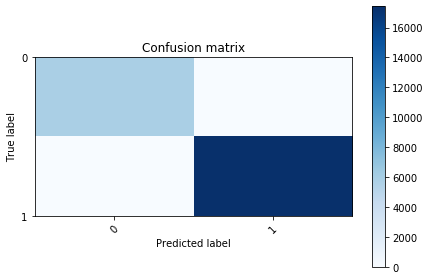


Accuracy

Final accuracy: 1.0

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.0061 - val_loss: 3.0714e-04
Epoch 2/200
93081/93081 - 12s - loss: 2.5797e-04 - val_loss: 3.0554e-04
Epoch 3/200
93081/93081 - 12s - loss: 1.3632e-04 - val_loss: 1.1950e-04
Epoch 4/200
93081/93081 - 12s - loss: 2.7482e-04 - val_loss: 1.8802e-04
Epoch 5/200
93081/93081 - 12s - loss: 1.1707e-04 - val_loss: 6.6003e-05
Epoch 6/200
93081/93081 - 12s - loss: 2.6873e-04 - val_loss: 3.8358e-05
Epoch 00006: early stopping

Confusion Matrix

[[ 5853     0]
 [   

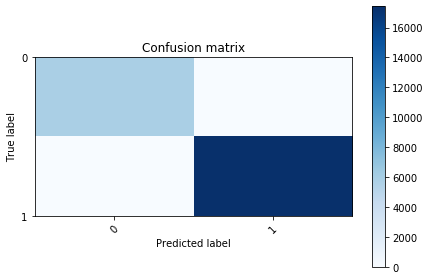


Accuracy

Final accuracy: 1.0

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 14s - loss: 0.0251 - val_loss: 0.0026
Epoch 2/200
93081/93081 - 11s - loss: 0.0015 - val_loss: 0.0014
Epoch 3/200
93081/93081 - 11s - loss: 8.8299e-04 - val_loss: 0.0013
Epoch 4/200
93081/93081 - 11s - loss: 5.1641e-04 - val_loss: 6.2352e-04
Epoch 5/200
93081/93081 - 11s - loss: 5.7297e-04 - val_loss: 0.0010
Epoch 6/200
93081/93081 - 11s - loss: 4.5629e-04 - val_loss: 9.4569e-04
Epoch 7/200
93081/93081 - 12s - loss: 4.0057e-04 - val_loss: 6.1976e-04
Epoch 00007: ear

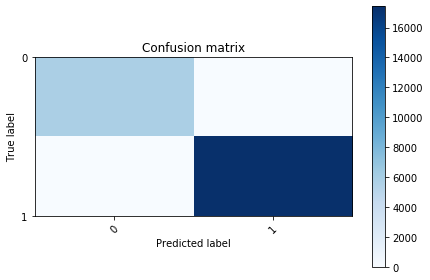


Accuracy

Final accuracy: 0.9998710841820291

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.2237 - val_loss: 0.0455
Epoch 2/200
93081/93081 - 11s - loss: 0.0231 - val_loss: 0.0123
Epoch 3/200
93081/93081 - 11s - loss: 0.0086 - val_loss: 0.0065
Epoch 4/200
93081/93081 - 11s - loss: 0.0050 - val_loss: 0.0044
Epoch 5/200
93081/93081 - 11s - loss: 0.0035 - val_loss: 0.0033
Epoch 6/200
93081/93081 - 11s - loss: 0.0026 - val_loss: 0.0026
Epoch 7/200
93081/93081 - 11s - loss: 0.0021 - val_loss: 0.0022
Epoch 8/200
93081/93081 - 11s 

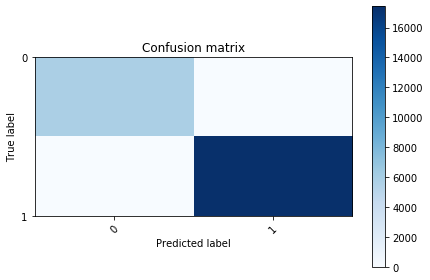


Accuracy

Final accuracy: 0.9998710841820291

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 13s - loss: 0.0220 - val_loss: 0.0037
Epoch 2/200
93081/93081 - 11s - loss: 0.0020 - val_loss: 0.0018
Epoch 3/200
93081/93081 - 11s - loss: 0.0011 - val_loss: 0.0012
Epoch 4/200
93081/93081 - 11s - loss: 7.6316e-04 - val_loss: 9.6718e-04
Epoch 5/200
93081/93081 - 11s - loss: 5.9108e-04 - val_loss: 7.4547e-04
Epoch 6/200
93081/93081 - 11s - loss: 4.6916e-04 - val_loss: 6.1655e-04
Epoch 7/200
93081/93081 - 11s - loss: 3.9144e-04 - val_loss: 6.0307e-04
E

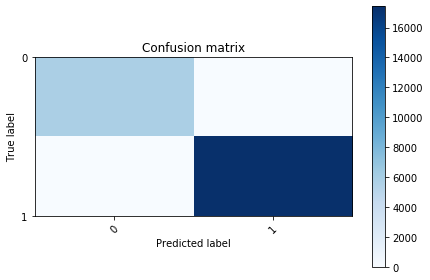


Accuracy

Final accuracy: 0.9998710841820291

Classification Report

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5853
           1       1.00      1.00      1.00     17418

    accuracy                           1.00     23271
   macro avg       1.00      1.00      1.00     23271
weighted avg       1.00      1.00      1.00     23271



In [40]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

checkpointer = ModelCheckpoint(filepath="best_weights_NN.hdf5", verbose=0, save_best_only=True)

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Dense(64, input_dim=x_train.shape[1], activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(y_train.shape[1],activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=opt)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
        
        pred_n = model.predict(x_test)
        pred_n = np.argmax(pred_n,axis=1)
        y_true = np.argmax(y_test,axis=1)
        score = metrics.accuracy_score(y_true, pred_n)
        
        print("\nConfusion Matrix\n")
        cm = confusion_matrix(y_true, pred_n)
        print(cm)
        plot_confusion_matrix(cm,['0','1'])
        
        print("\nAccuracy\n")
        print("Final accuracy: {}".format(score))
        
        
        print("\nClassification Report\n")
        
        print(metrics.classification_report(y_true, pred_n))
        model.load_weights('best_weights_NN.hdf5')



# Feature selection

In [41]:
data_f = pd.read_csv("df.csv",na_values=['na','-'])

In [42]:
data_f.drop(labels=['id'],axis=1,inplace=True)

In [43]:
data_f.dropna(axis=0,inplace=True)


In [44]:
data_f.shape

(116352, 44)

In [45]:
encode_text_dummy(data_f,'service')
encode_text_dummy(data_f,'proto')
encode_text_dummy(data_f,'state')
encode_text_dummy(data_f,'attack_cat')

In [46]:
data_f.shape

(116352, 69)

In [47]:
x = data_f.drop(['label'], axis = 1, inplace=False)
y = data_f.loc[:,'label']

Corelation Function to find best corelated rows

In [48]:
cor = x.corr()

In [49]:
columns = np.full((cor.shape[0],), True, dtype=bool)
for i in range(cor.shape[0]):
    for j in range(i+1, cor.shape[0]):
        if cor.iloc[i,j] >= 0.3:
            if columns[j]:
                columns[j] = False
selected_columns = x.columns[columns]
x = x[selected_columns]

In [50]:
x.shape

(116352, 21)

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [52]:
for column in x_train:
    encode_numeric_zscore(x_train, column)
    encode_numeric_zscore(x_test, column)

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Prerak\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [53]:
x_train

,dur,rate,dttl,dload,trans_depth,is_ftp_login,is_sm_ips_ports,service-dhcp,service-ftp-data,service-irc,...,service-snmp,service-ssh,service-ssl,state-ACC,state-CON,state-RST,attack_cat-Backdoor,attack_cat-DoS,attack_cat-Reconnaissance,attack_cat-Worms
229971,-0.198723,1.351789,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
126958,-0.198721,0.028595,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
119999,-0.198722,0.557873,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
155035,-0.198721,0.028595,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
225964,-0.198721,-0.091695,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170272,-0.198721,0.028595,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
233053,-0.198721,-0.091695,-0.712836,-0.215505,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
219220,0.571947,-0.632887,1.559504,-0.210209,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,-0.321584,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667
2897,-0.198447,-0.616733,-0.451337,0.447382,-0.193572,-0.164608,NaN,-0.032298,-0.2212,-0.017654,...,-0.031794,-0.115338,-0.026839,NaN,3.109570,-0.011819,-0.031625,-0.148863,-0.139507,-0.03667


In [54]:
x_train.drop(labels=['is_sm_ips_ports'],axis=1,inplace=True)
x_test.drop(labels=['is_sm_ips_ports'],axis=1,inplace=True)
x_train.drop(labels=['state-ACC'],axis=1,inplace=True)
x_test.drop(labels=['state-ACC'],axis=1,inplace=True)

C:\Users\Prerak\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

lr=LogisticRegression()
lr.fit(x_train,y_train)

C:\Users\Prerak\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
y_pred = lr.predict(x_test)


[[ 4870   925]
 [  116 17360]]


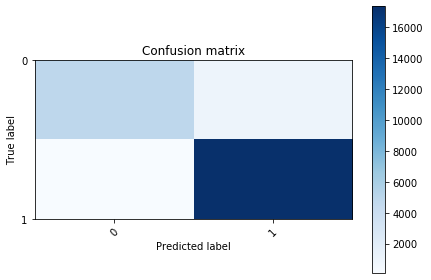

In [57]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [58]:
print('Accuracy of logistic regression classifier: {}'.format(lr.score(x_test, y_test)))
print(classification_report(y_test,y_pred))

Accuracy of logistic regression classifier: 0.9552662111641098
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      5795
           1       0.95      0.99      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.96      0.92      0.94     23271
weighted avg       0.96      0.96      0.95     23271



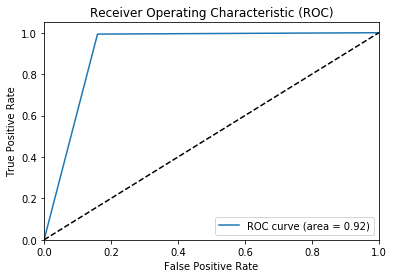

In [59]:
plot_roc(y_pred,y_test)

SVM

In [60]:
from sklearn.svm import SVC
svm_object = SVC(kernel = 'rbf')
svm_object.fit(x_train, y_train)
y_pred = svm_object.predict(x_test)

C:\Users\Prerak\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[ 4884   911]
 [   34 17442]]


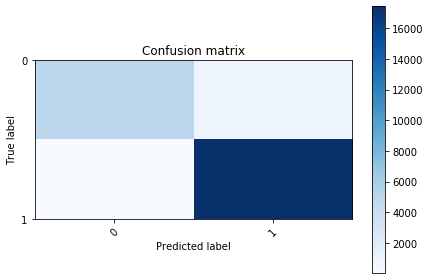

In [61]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

In [62]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.9593915173391775
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5795
           1       0.95      1.00      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.97      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271



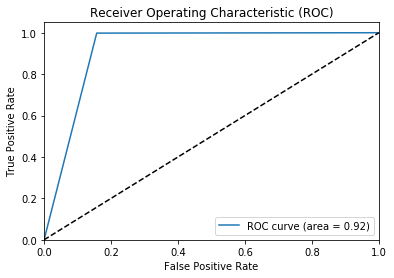

In [63]:
plot_roc(y_pred,y_test)

KNN(5-neighbors)

In [64]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

[[ 4884   911]
 [   34 17442]]


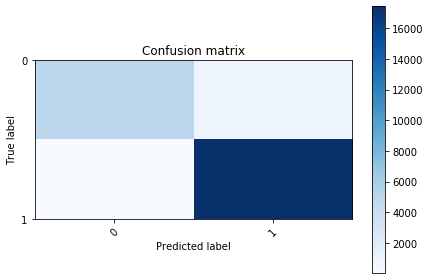

In [65]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
plot_confusion_matrix(cm,['0','1'])

Accuracy: 0.9593915173391775
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5795
           1       0.95      0.99      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.96      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271



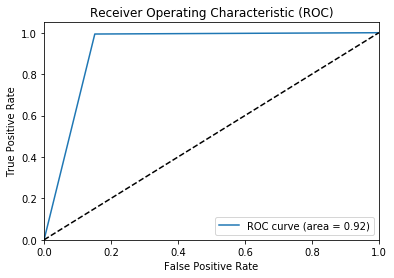

In [66]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
y_pred = knn.predict(x_test)
print(classification_report(y_test,y_pred))
plot_roc(y_pred,y_test)

Neural Networks

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [68]:
x_train.values.astype(np.float32)
x_test.values.astype(np.float32)

array([[-0.1950589 ,  0.02104987, -0.7100769 , ..., -0.14665684,
        -0.13720419, -0.03145298],
       [ 0.06225858, -0.63170284,  1.564549  , ..., -0.14665684,
        -0.13720419, -0.03145298],
       [ 1.857811  , -0.6317741 ,  1.564549  , ..., -0.14665684,
        -0.13720419, -0.03145298],
       ...,
       [-0.05459858, -0.63163805,  1.564549  , ..., -0.14665684,
        -0.13720419, -0.03145298],
       [-0.19505914,  0.10265666, -0.7100769 , ..., -0.14665684,
        -0.13720419, -0.03145298],
       [-0.12719716, -0.6314198 , -0.44831443, ..., -0.14665684,
        -0.13720419, -0.03145298]], dtype=float32)

In [69]:
y_train = to_categorical(y_train)             #don't do again and again
y_test = to_categorical(y_test)            #don't do again and again




Model trained for "adam" optimizer and "relu" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.1177 - val_loss: 0.1171
Epoch 2/200
93081/93081 - 12s - loss: 0.0989 - val_loss: 0.1049
Epoch 3/200
93081/93081 - 13s - loss: 0.0965 - val_loss: 0.1106
Epoch 4/200
93081/93081 - 12s - loss: 0.0952 - val_loss: 0.1217
Epoch 5/200
93081/93081 - 12s - loss: 0.0944 - val_loss: 0.1402
Epoch 6/200
93081/93081 - 12s - loss: 0.0944 - val_loss: 0.1315
Epoch 7/200
93081/93081 - 12s - loss: 0.0936 - val_loss: 0.1244
Epoch 00007: early stopping

Confusion Matrix

[[ 4877   918]
 [   32 17444]]


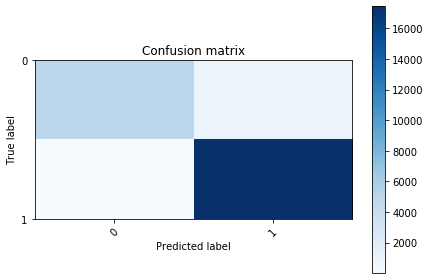


Accuracy

Final accuracy: 0.9591766576425594

Classification Report

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5795
           1       0.95      1.00      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.97      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271




Model trained for "adam" optimizer and "sigmoid" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.1756 - val_loss: 0.2415
Epoch 2/200
93081/93081 - 12s - loss: 0.1227 - val_loss: 0.1245
Epoch 3/200
93081/93081 - 11s - loss: 0.1154 - val_loss: 0.1283
Epoch 4/200
93081/93081 - 11s - loss: 0.1106 - val_loss: 0.1205
Epoch 5/200
93081/93081 - 11s - loss: 0.1070 - val_loss: 0.1054
Epoch 6/200
93081/93081 - 11s - loss: 0.1051 - val_loss: 0.1203
Epoch 7/200
93081/93081 - 11s - loss: 0.1038 - val_loss: 0.1063
Epoch 8/200
93081/93081 - 12s

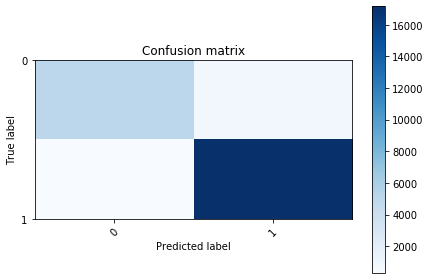


Accuracy

Final accuracy: 0.9529027545013107

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      5795
           1       0.96      0.98      0.97     17476

    accuracy                           0.95     23271
   macro avg       0.95      0.92      0.94     23271
weighted avg       0.95      0.95      0.95     23271




Model trained for "adam" optimizer and "tanh" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.1251 - val_loss: 0.1150
Epoch 2/200
93081/93081 - 11s - loss: 0.1035 - val_loss: 0.1094
Epoch 3/200
93081/93081 - 12s - loss: 0.0965 - val_loss: 0.0976
Epoch 4/200
93081/93081 - 11s - loss: 0.0932 - val_loss: 0.1055
Epoch 5/200
93081/93081 - 11s - loss: 0.0915 - val_loss: 0.1089
Epoch 6/200
93081/93081 - 11s - loss: 0.0909 - val_loss: 0.1190
Epoch 7/200
93081/93081 - 12s - loss: 0.0904 - val_loss: 0.1087
Epoch 8/200
93081/93081 - 11s - 

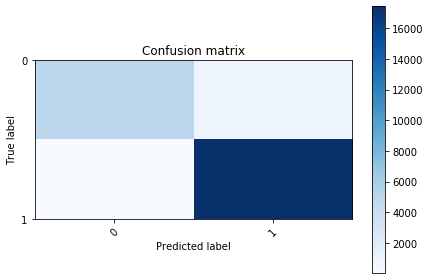


Accuracy

Final accuracy: 0.958875854067294

Classification Report

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5795
           1       0.95      1.00      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.97      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271




Model trained for "sgd" optimizer and "relu" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 12s - loss: 0.1744 - val_loss: 0.1332
Epoch 2/200
93081/93081 - 11s - loss: 0.1166 - val_loss: 0.1406
Epoch 3/200
93081/93081 - 11s - loss: 0.1115 - val_loss: 0.1331
Epoch 4/200
93081/93081 - 11s - loss: 0.1095 - val_loss: 0.1210
Epoch 5/200
93081/93081 - 11s - loss: 0.1080 - val_loss: 0.1253
Epoch 6/200
93081/93081 - 11s - loss: 0.1069 - val_loss: 0.1115
Epoch 7/200
93081/93081 - 11s - loss: 0.1061 - val_loss: 0.1101
Epoch 8/200
93081/93081 - 11s - lo

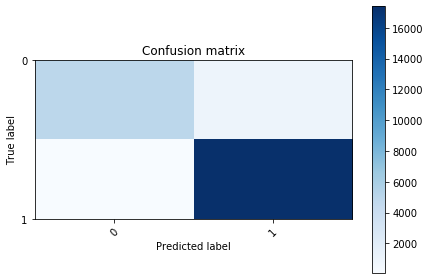


Accuracy

Final accuracy: 0.957973443341498

Classification Report

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5795
           1       0.95      1.00      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.97      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271




Model trained for "sgd" optimizer and "sigmoid" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 11s - loss: 0.4876 - val_loss: 0.3682
Epoch 2/200
93081/93081 - 11s - loss: 0.2956 - val_loss: 0.2277
Epoch 3/200
93081/93081 - 11s - loss: 0.2126 - val_loss: 0.2265
Epoch 4/200
93081/93081 - 11s - loss: 0.1766 - val_loss: 0.2743
Epoch 5/200
93081/93081 - 11s - loss: 0.1616 - val_loss: 0.2890
Epoch 6/200
93081/93081 - 11s - loss: 0.1530 - val_loss: 0.3116
Epoch 7/200
93081/93081 - 11s - loss: 0.1467 - val_loss: 0.3117
Epoch 8/200
93081/93081 - 11s -

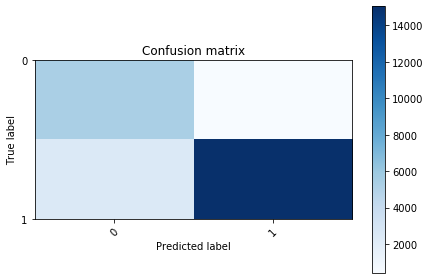


Accuracy

Final accuracy: 0.8769713377164712

Classification Report

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      5795
           1       0.97      0.86      0.91     17476

    accuracy                           0.88     23271
   macro avg       0.83      0.89      0.85     23271
weighted avg       0.90      0.88      0.88     23271




Model trained for "sgd" optimizer and "tanh" activation function : 

Train on 93081 samples, validate on 23271 samples
Epoch 1/200
93081/93081 - 11s - loss: 0.1791 - val_loss: 0.2054
Epoch 2/200
93081/93081 - 11s - loss: 0.1223 - val_loss: 0.1515
Epoch 3/200
93081/93081 - 12s - loss: 0.1161 - val_loss: 0.1370
Epoch 4/200
93081/93081 - 11s - loss: 0.1133 - val_loss: 0.1297
Epoch 5/200
93081/93081 - 12s - loss: 0.1115 - val_loss: 0.1181
Epoch 6/200
93081/93081 - 11s - loss: 0.1102 - val_loss: 0.1247
Epoch 7/200
93081/93081 - 11s - loss: 0.1088 - val_loss: 0.1253
Epoch 8/200
93081/93081 - 11s - l

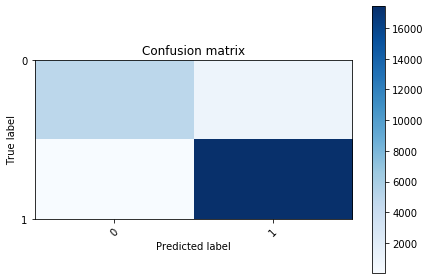


Accuracy

Final accuracy: 0.9580164152808216

Classification Report

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      5795
           1       0.95      1.00      0.97     17476

    accuracy                           0.96     23271
   macro avg       0.97      0.92      0.94     23271
weighted avg       0.96      0.96      0.96     23271



In [70]:
optimizers = ['adam','sgd']
activation_functions = ['relu','sigmoid','tanh']

checkpointer = ModelCheckpoint(filepath="best_weights_NN_best.hdf5", verbose=0, save_best_only=True)

for opt in optimizers:
    for act in activation_functions:

        print("\n\n\nModel trained for \"{}\" optimizer and \"{}\" activation function : \n".format(opt,act))
        
        model = Sequential()
        model.add(Dense(64, input_dim=x_train.shape[1], activation=act))
        model.add(Dense(32,activation=act))
        model.add(Dense(y_train.shape[1],activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer=opt)

        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

        model.fit(x_train, y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=200)
        
        pred_n = model.predict(x_test)
        pred_n = np.argmax(pred_n,axis=1)
        y_true = np.argmax(y_test,axis=1)
        score = metrics.accuracy_score(y_true, pred_n)
        
        print("\nConfusion Matrix\n")
        cm = confusion_matrix(y_true, pred_n)
        print(cm)
        plot_confusion_matrix(cm,['0','1'])
        
        print("\nAccuracy\n")
        print("Final accuracy: {}".format(score))
        
        
        print("\nClassification Report\n")
        
        print(metrics.classification_report(y_true, pred_n))
        model.load_weights('best_weights_NN_best.hdf5')